## __<font color=blue>Google</font> Data Analytics Case Study : Cyclistic__

### Case Study Backdrop
As a junior data analyst working under Cyclistic's marketing team in Chicago, this assignment involves understanding,cleaning ,preprocessing, exxploring , analysing and visualizing relevant data to identify trends that will assist the marketing team to gather relevelant uncovered insights and present the findings and counsel to the company director and executives.

### Project Scope






    

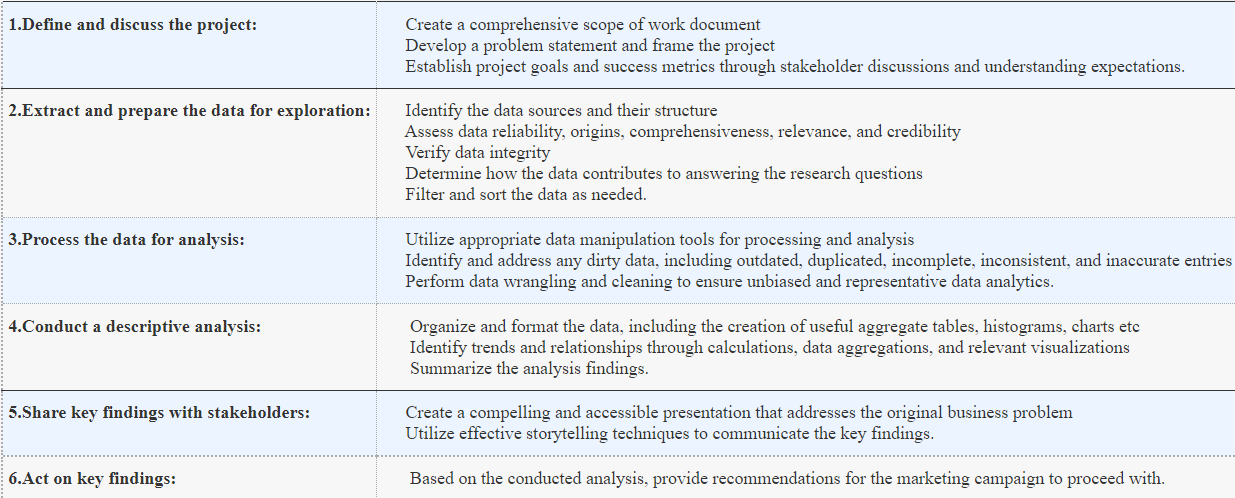

### Company background:
#### Current business model:
    
Product: The product offered is a bike-sharing service with geotracked and network locked bikes available throughout Chicago.

Customer types and revenue model: The customer base consists of two main categories: members, who are annual subscribers, and casual riders, who make single-ride or full-day purchases. The revenue model is based on these customer segments.

Competitive advantages: The company possesses competitive advantages in terms of bicycle variety, catering to a wide range of consumer segments, and pricing flexibility, allowing for adaptable pricing options.

#### Product info:
   1.Features more than 5,800 bicycles and 600 docking stations.</br>
   2.The majority of riders opt for traditional bikes.</br>
   3.Also offering reclining bikes, hand tricycles, and cargo bikes</br>
   4.8% of total riders use the assistive options.</br>
   5.About 30% of users use bikes to commute to work each day</br>
   6.Cyclistic users are more likely to ride for leisure.</br>
    

Problem Statement

The Chicago based company wants to migrate a huge portion of its customer from traditional casual customers to a bigger chunk of yearly subscribers.The existing marketing management believes that the existing casual user database acts as a plausible domain to expand their vision. If this proposed strategy works then the marketing campaign may lead to a more dependable sustainable revenue.The analyst needs to analyse the stark differences between the existin casual and yearly riders and look for concrete evidences to help the marketing strategy case.

Goals and Expectations

Data Source and Organization

Data Quality Assessment

Integrity


Filtering

Library modules and helper functions

In [14]:
import numpy as np                        # efficient data types
import csv                                # csv handling
import os                                 # data file path handling
import glob                               # pathnames matching
import pandas as pd                       # data manipulation and analysis
import warnings                           # eliminate markdown warnings
import matplotlib.pyplot as plt           # plotting visuals
import seaborn as sns                     # visualization module

import difflib                            # comparing strings
import re                                 # pattern matching 

Data preview

In [15]:
cycle= pd.read_csv('Divvy_Trips_2020_Q1.csv')
cycle

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,EACB19130B0CDA4A,docked_bike,2020-01-21 20:06:59,2020-01-21 20:14:30,Western Ave & Leland Ave,239,Clark St & Leland Ave,326.0,41.9665,-87.6884,41.9671,-87.6674,member
1,8FED874C809DC021,docked_bike,2020-01-30 14:22:39,2020-01-30 14:26:22,Clark St & Montrose Ave,234,Southport Ave & Irving Park Rd,318.0,41.9616,-87.6660,41.9542,-87.6644,member
2,789F3C21E472CA96,docked_bike,2020-01-09 19:29:26,2020-01-09 19:32:17,Broadway & Belmont Ave,296,Wilton Ave & Belmont Ave,117.0,41.9401,-87.6455,41.9402,-87.6530,member
3,C9A388DAC6ABF313,docked_bike,2020-01-06 16:17:07,2020-01-06 16:25:56,Clark St & Randolph St,51,Fairbanks Ct & Grand Ave,24.0,41.8846,-87.6319,41.8918,-87.6206,member
4,943BC3CBECCFD662,docked_bike,2020-01-30 08:37:16,2020-01-30 08:42:48,Clinton St & Lake St,66,Wells St & Hubbard St,212.0,41.8856,-87.6418,41.8899,-87.6343,member
...,...,...,...,...,...,...,...,...,...,...,...,...,...
426882,ADDAA33CEBCAE733,docked_bike,2020-03-10 10:40:06,2020-03-10 10:40:07,HQ QR,675,HQ QR,675.0,41.8899,-87.6803,41.8899,-87.6803,casual
426883,82B10FA3994BC66A,docked_bike,2020-03-07 15:25:55,2020-03-07 16:14:03,Rush St & Superior St,161,Sheridan Rd & Irving Park Rd,240.0,41.8958,-87.6259,41.9542,-87.6544,member
426884,AA0D5AAA0B59C8AA,docked_bike,2020-03-01 13:12:38,2020-03-01 13:38:29,Clark St & Lincoln Ave,141,Ashland Ave & Division St,210.0,41.9157,-87.6346,41.9035,-87.6677,casual
426885,3296360A7BC20FB8,docked_bike,2020-03-07 18:02:45,2020-03-07 18:13:18,Franklin St & Illinois St,672,Stetson Ave & South Water St,264.0,41.8910,-87.6355,41.8868,-87.6223,member


Cross Checking data location

Using the histogram function to check whether the majority of users from the latitude and longitude of parked bikes given belong to Chicago city

array([[<Axes: title={'center': 'start_lat'}>,
        <Axes: title={'center': 'start_lng'}>],
       [<Axes: title={'center': 'end_lat'}>,
        <Axes: title={'center': 'end_lng'}>]], dtype=object)

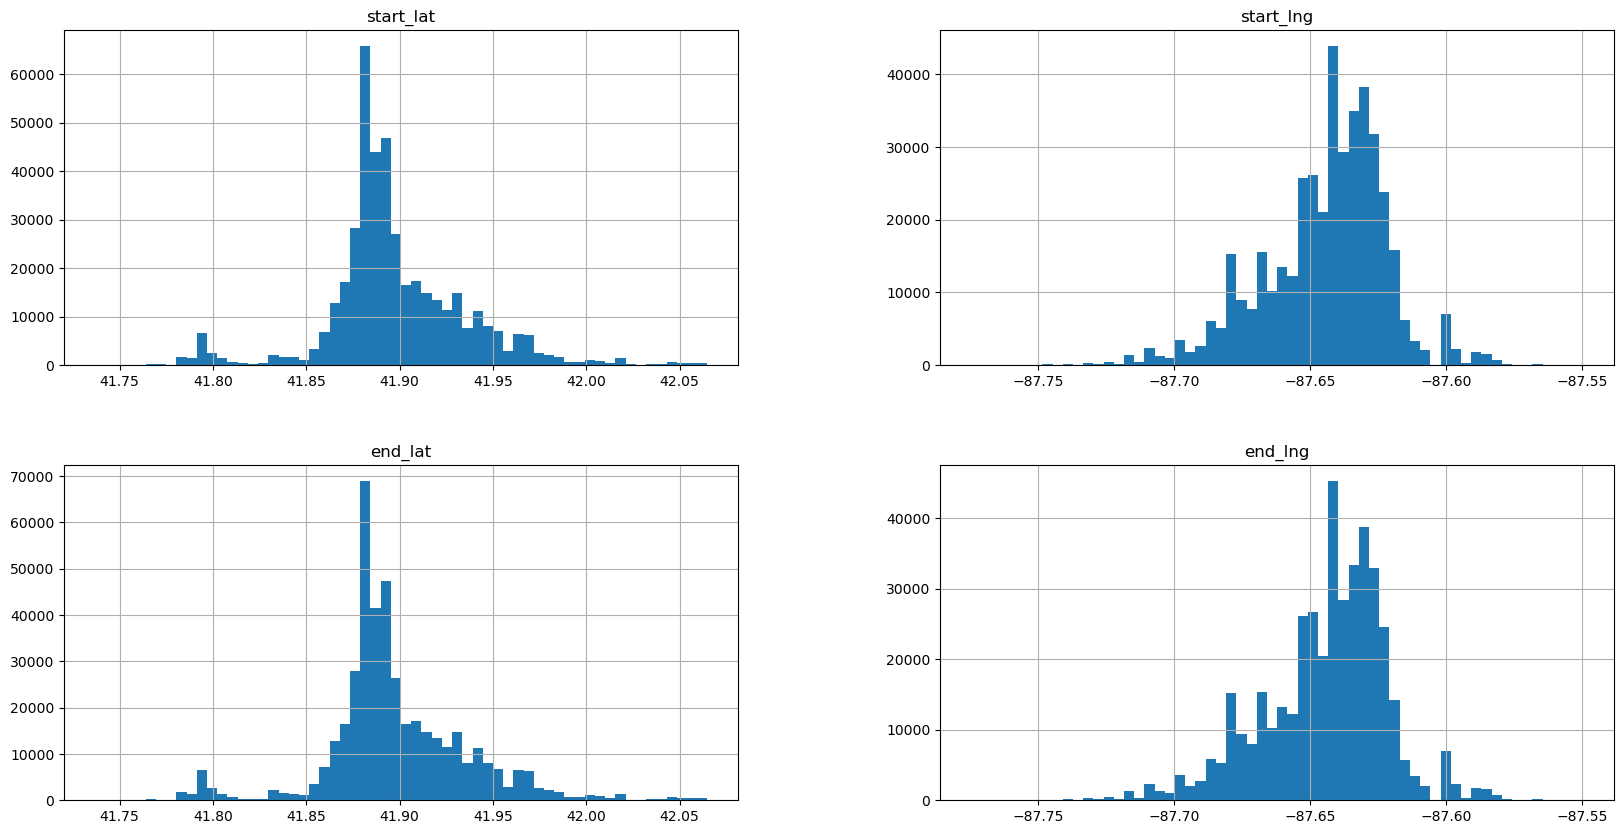

In [16]:
cycle_new.hist(bins=60 , figsize=(20,10))

In [18]:
cycle.columns



Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual'],
      dtype='object')

In [19]:
cycle_new = cycle[['rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'end_station_name', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual']]
cycle_new

,rideable_type,started_at,ended_at,start_station_name,end_station_name,start_lat,start_lng,end_lat,end_lng,member_casual
0,docked_bike,2020-01-21 20:06:59,2020-01-21 20:14:30,Western Ave & Leland Ave,Clark St & Leland Ave,41.9665,-87.6884,41.9671,-87.6674,member
1,docked_bike,2020-01-30 14:22:39,2020-01-30 14:26:22,Clark St & Montrose Ave,Southport Ave & Irving Park Rd,41.9616,-87.6660,41.9542,-87.6644,member
2,docked_bike,2020-01-09 19:29:26,2020-01-09 19:32:17,Broadway & Belmont Ave,Wilton Ave & Belmont Ave,41.9401,-87.6455,41.9402,-87.6530,member
3,docked_bike,2020-01-06 16:17:07,2020-01-06 16:25:56,Clark St & Randolph St,Fairbanks Ct & Grand Ave,41.8846,-87.6319,41.8918,-87.6206,member
4,docked_bike,2020-01-30 08:37:16,2020-01-30 08:42:48,Clinton St & Lake St,Wells St & Hubbard St,41.8856,-87.6418,41.8899,-87.6343,member
...,...,...,...,...,...,...,...,...,...,...
426882,docked_bike,2020-03-10 10:40:06,2020-03-10 10:40:07,HQ QR,HQ QR,41.8899,-87.6803,41.8899,-87.6803,casual
426883,docked_bike,2020-03-07 15:25:55,2020-03-07 16:14:03,Rush St & Superior St,Sheridan Rd & Irving Park Rd,41.8958,-87.6259,41.9542,-87.6544,member
426884,docked_bike,2020-03-01 13:12:38,2020-03-01 13:38:29,Clark St & Lincoln Ave,Ashland Ave & Division St,41.9157,-87.6346,41.9035,-87.6677,casual
426885,docked_bike,2020-03-07 18:02:45,2020-03-07 18:13:18,Franklin St & Illinois St,Stetson Ave & South Water St,41.8910,-87.6355,41.8868,-87.6223,member


Checking datatypes and sum 

In [20]:
cycle_new.isna().sum()


rideable_type         0
started_at            0
ended_at              0
start_station_name    0
end_station_name      1
start_lat             0
start_lng             0
end_lat               1
end_lng               1
member_casual         0
dtype: int64

In [21]:
cycle_new[cycle_new['end_station_name'].isna()]

,rideable_type,started_at,ended_at,start_station_name,end_station_name,start_lat,start_lng,end_lat,end_lng,member_casual
414426,docked_bike,2020-03-16 11:23:36,2020-03-16 11:23:24,HQ QR,NaN,41.8899,-87.6803,NaN,NaN,casual


In [22]:
cycle_new.dtypes 

rideable_type          object
started_at             object
ended_at               object
start_station_name     object
end_station_name       object
start_lat             float64
start_lng             float64
end_lat               float64
end_lng               float64
member_casual          object
dtype: object

In [24]:
cycle_new.dtypes


rideable_type          object
started_at             object
ended_at               object
start_station_name     object
end_station_name       object
start_lat             float64
start_lng             float64
end_lat               float64
end_lng               float64
member_casual          object
dtype: object

C:\Users\Shreyas.Challiyil\AppData\Local\Temp\ipykernel_14728\2390258710.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cycle_new['rideable_type'] = cycle_new['rideable_type'].astype(str)


In [13]:
cycle_new[['member_casual','rideable_type']].plot(kind='bar', x='member_casual', y='rideable_type')

TypeError: no numeric data to plot